# A representative subset of AotM-2011 Playlists with MSD Audio Features

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import lil_matrix, issparse
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from BinaryRelevance import BinaryRelevance
from PClassificationMLC import PClassificationMLC
from evaluate import calc_F1, calc_precisionK, f1_score_nowarn

In [3]:
data_dir = 'data/aotm-2011'
#faotm = os.path.join(data_dir, 'aotm2011-subset.pkl')
faotm = os.path.join(data_dir, 'aotm2011-user-playlist.pkl')
ffeature = 'data/msd/songID2Features.pkl.gz'

## Load playlists

Load playlists.

In [4]:
user_playlists = pkl.load(open(faotm, 'rb'))

In [5]:
print('#user    :', len(user_playlists))
print('#playlist:', np.sum([len(user_playlists[u]) for u in user_playlists]))

#user    : 14182
#playlist: 84710


In [6]:
pl_lengths = [len(pl) for u in user_playlists for pl in user_playlists[u]]
#plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

Average playlist length: 10.1


In [7]:
users = sorted(user_playlists.keys())

In [8]:
songs_user = {u: {sid for pl in user_playlists[u] for sid in pl} for u in users}  # user: a set of songs

Compute the number of playlists per user, and the number of songs covered by the user's playlists.

In [9]:
udf = pd.DataFrame(index=users, columns=['#playlist', '#song'])

In [10]:
udf['#playlist'] = [len(user_playlists[u]) for u in users]

In [11]:
udf['#song'] = [len(songs_user[u]) for u in users]

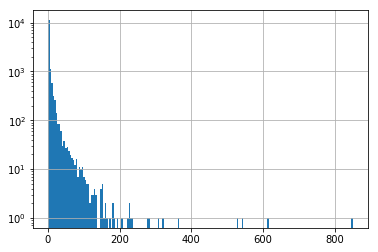

In [350]:
ax = plt.subplot(111)
udf['#playlist'].hist(bins=200, ax=ax)
ax.set_yscale('log')

In [119]:
uid_subset = []

In [120]:
udf_subset = udf[ udf['#playlist'] == 10]
udf_subset.head()

,#playlist,#song
"(921243600.0, McDermott)",10,79
"(923925600.0, W.12)",10,82
"(934120800.0, The J-Dogg)",10,93
"(937663200.0, Wemple)",10,102
"(942498000.0, Lang1)",10,115


In [123]:
uid_subset.append(udf_subset.index[3])

In [124]:
udf_subset = udf[ udf['#playlist'] == 30]
udf_subset.head()

,#playlist,#song
"(965311200.0, radiozilla)",30,181
"(966261600.0, Em)",30,266
"(967986000.0, zwirnm)",30,218
"(985615200.0, agnamaracs)",30,325
"(993045600.0, kgp.)",30,227


In [125]:
uid_subset.append(udf_subset.index[1])

In [133]:
udf_subset = udf[ udf['#playlist'] == 98]
udf_subset.head()

,#playlist,#song
"(958572000.0, Lorentz)",98,1042
"(1036846800.0, Slack-a-gogo)",98,935
"(1046005200.0, Shiki)",98,777
"(1077022800.0, spunk these)",98,658


In [134]:
uid_subset.append(udf_subset.index[1])

In [13]:
#udf.sort_values(by=['#playlist'], ascending=False).iloc[100:200]

In [135]:
uid_subset

[(937663200.0, 'Wemple'), (966261600.0, 'Em'), (1036846800.0, 'Slack-a-gogo')]

In [15]:
#udf[uid_subset]  # tuple are used as multiindex in pandas
#udf[[uid_subset]]

## Subset of data

The user whose playlists cover a *proper number of playlists*, e.g. 50.

In [138]:
playlists_subset = [pl for u in uid_subset for pl in user_playlists[u]]

In [139]:
song_set = sorted({sid for u in uid_subset for sid in songs_user[u]})

In [140]:
len(song_set)

1285

In [141]:
#song_set

## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [142]:
song2Features = pkl.load(gzip.open(ffeature, 'rb'))

The set of songs, which is the set of labels in this formulation.

## Split song-playlist matrix

Songs as rows, playlists as columns, split rows.

In [143]:
def gen_dataset_subset(playlists, song_set, features_MSD):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - song_set: a set of songIDs
        - features_MSD: dictionary that maps songIDs to features from MSD
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """
    song_indices = {sid: ix for ix, sid in enumerate(song_set)}
    N = len(song_set)
    K = len(playlists)
    
    X = np.array([features_MSD[sid] for sid in song_set])
    Y = np.zeros((N, K), dtype=np.bool)
    
    for k in range(K):
        pl = playlists[k]
        indices = [song_indices[sid] for sid in pl]
        Y[indices, k] = True

    return X, Y

In [202]:
X, Y = gen_dataset_subset(playlists=playlists_subset, song_set=song_set, features_MSD=song2Features)

# data split: approximately 80/20 for training/dev
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, random_state=8976321)

# feature normalisation
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = 100 * np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev   -= X_train_mean
X_dev   /= X_train_std

In [203]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

Train:     (1028, 202)     (1028, 138)
Dev  :      (257, 202)      (257, 138)


In [204]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 0.01)
print(np.mean(np.mean(X_dev, axis=0)))
print(np.mean( np.std(X_dev, axis=0)) - 0.01)

-3.34576114974e-18
-0.000297031551481
-5.67389855057e-05
0.000249339240116


## BR - Independent logistic regression

Independent logistic regression.

In [205]:
br = BinaryRelevance(n_jobs=4)
br.fit(X_train, Y_train)

In [206]:
Y_br = br.predict(X_dev)

In [207]:
np.mean(calc_precisionK(Y_dev.T, Y_br.T))

0.16414768806073154

In [208]:
f1_score_nowarn(Y_dev.ravel(), (Y_br>=0).ravel(), average='binary')

0.0

In [213]:
precision_recall_fscore_support(Y_dev.ravel(), (Y_br>=0).ravel(), average='binary', warn_for=())

(0.0, 0.0, 0.0, None)

In [214]:
#np.mean(calc_F1(Y_train, br.predict(X_train) >= 0))

In [215]:
%%script false
min_pos_score = []
for col in range(Y_dev.shape[1]):
    val = Y_br[:,col][Y_dev[:,col]]
    if len(val) > 0:
        min_pos_score.append(np.min(val))
    else:
        min_pos_score.append(np.nan)
print(np.array(min_pos_score))

In [216]:
%%script false
max_neg_score = []
for col in range(Y_dev.shape[1]):
    val = Y_br[:,col][np.logical_not(Y_dev[:,col])]
    if len(val) > 0:
        max_neg_score.append(np.max(val))
print(np.array(max_neg_score))

In [217]:
#print(np.array(min_pos_score)-np.array(max_neg_score))

## PC - Multilabel p-classification

P-Classification ~ P-norm push ranking.

In [218]:
pc1 = PClassificationMLC(C=1, weighting=True, verticalWeighting=True)
pc1.fit(X_train, Y_train)


C: 1, p: 1, weighting: True


In [219]:
X_test = X_dev
Y_test = Y_dev

In [220]:
np.sum(Y_dev, axis=0)

array([4, 2, 4, 0, 2, 2, 1, 3, 2, 3, 4, 3, 2, 3, 0, 0, 3, 3, 1, 4, 2, 1, 5,
       6, 4, 4, 7, 3, 5, 3, 1, 3, 0, 4, 1, 0, 8, 4, 3, 3, 5, 2, 2, 2, 1, 3,
       2, 3, 1, 5, 1, 4, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 4, 2, 0, 3, 4, 2,
       1, 0, 2, 1, 0, 5, 1, 1, 2, 1, 1, 1, 0, 5, 3, 2, 0, 3, 1, 2, 5, 0, 3,
       4, 1, 1, 1, 4, 2, 0, 2, 2, 1, 3, 3, 1, 3, 3, 0, 1, 1, 1, 3, 1, 2, 3,
       1, 2, 4, 3, 4, 4, 3, 1, 1, 0, 0, 5, 1, 2, 4, 2, 1, 3, 1, 2, 1, 1, 2])

In [221]:
Y_pc = pc1.predict(X_test)

In [222]:
np.mean(calc_precisionK(Y_test.T, Y_pc.T))

0.16414768806073154

In [223]:
precision_recall_fscore_support(Y_dev.ravel(), (Y_pc>=0).ravel(), average='binary', warn_for=None)

(0.021719659650694133, 0.32441471571906355, 0.040713536201469051, None)

In [224]:
#np.mean(calc_F1(Y_dev, Y_pc >= 0))

In [225]:
#np.mean(calc_F1(Y_train, pc.predict(X_train) >= 0))

In [226]:
min_pos_score = []
for col in range(Y_test.shape[1]):
    val = Y_pc[:,col][Y_test[:,col]]
    if len(val) > 0:
        min_pos_score.append(np.min(val))
    else:
        min_pos_score.append(np.nan)
#plt.hist((np.array(min_pos_score)))
#plt.hist((np.nan_to_num(min_pos_score)), bins=30)
#print(np.array(min_pos_score))
#print()

In [227]:
max_neg_score = []
for col in range(Y_test.shape[1]):
    val = Y_pc[:,col][np.logical_not(Y_test[:,col])]
    if len(val) > 0:
        max_neg_score.append(np.max(val))
#plt.hist(np.array(max_neg_score), bins=30)
#print()

In [228]:
#plt.hist(np.nan_to_num(min_pos_score)-np.array(max_neg_score), bins=30)
#print()

## Multilabel p-classification with unknows in test set

In [229]:
N, K = Y.shape

In [230]:
#type(np.nan)

In [231]:
Y_nan = Y.copy().astype(np.float)
np.random.seed(8967321)
rand_num = int(0.2 * N)
ones = 0
for k in range(K):
    randix = np.random.permutation(np.arange(N))[:rand_num]
    Y_nan[randix, k] = np.nan
    ones += Y[randix, k].sum()

In [232]:
#np.sum(Y, axis=0)

In [233]:
#np.nansum(Y_nan, axis=0)

In [234]:
#np.sum(Y, axis=0) - np.nansum(Y_nan, axis=0)

In [235]:
#ones  # number of positive entries selected to be masked as NaN

In [236]:
#Y.shape

In [237]:
#Y_nan.shape

The number of NaN entries.

In [238]:
np.sum(np.isnan(Y_nan))

35466

In [239]:
#np.sum(Y)

Train: *keep running util no overflow warning occurred*.

In [298]:
pc2 = PClassificationMLC(weighting=True, verticalWeighting=True)
pc2.fit(X, Y_nan)


C: 1, p: 1, weighting: True
J: 0.214785992218
J: 6.36113460143e+245
J: 1.38807130597e+79
J: 5.33063012377e+23
J: 242128.662034
J: 0.551712181378
J: 0.211225405554
J: 0.207650141065
J: 0.205182069412
J: 0.202772293121
J: 0.199746631232
J: 0.195279375789
J: 0.191344585106
J: 0.188397775893
J: 0.185760032793
J: 0.184108651849
J: 0.181354623225
J: 0.181138422759
J: 0.179595338381
J: 0.177916861047
J: 0.17674074268
J: 0.17538347649
J: 0.173742360014
J: 0.171877736237
J: 0.169636642184
J: 0.168189957215
J: 0.168377986119
J: 0.166824886343
J: 0.165366676886
J: 0.164487879363
J: 0.163765265903
J: 0.162694500449
J: 0.161787369452
J: 0.160751225081
J: 0.159871678331
J: 0.159002221173
J: 0.158496136294
J: 0.157138304732
J: 0.157384304412
J: 0.156552633148
J: 0.155871059442
J: 0.155026947679
J: 0.154537230832
J: 0.154103248287
J: 0.153651191007
J: 0.153193019583
J: 0.152688320539
J: 0.152112341167
J: 0.15153600484
J: 0.151077674879
J: 0.150716046988
J: 0.150393310302
J: 0.150074110576
J: 0.149699

Prediction: use the minimum of positive entry score of the same example as threshold.  
Evaluation: use F1 on all unknown entries (as a 1D array).

In [299]:
Y_pred2 = pc2.predict(X)

In [300]:
pos_index = np.nan_to_num(Y_nan).astype(np.bool)
nan_index = np.isnan(Y_nan)

In [301]:
ground_truths = Y[nan_index]

In [302]:
thresholds = []
preds = []
for k in range(K):
    val = Y_pred2[:, k][pos_index[:, k]]
    th = np.min(val)
    thresholds.append(th)
    preds += (Y_pred2[nan_index[:,k], k] >= th).tolist()

In [303]:
f1_score_nowarn(ground_truths, preds, average='binary')

0.011003117549972491

In [304]:
precision_recall_fscore_support(ground_truths, preds, average='binary', warn_for=None)

(0.0058184639255236615, 0.10101010101010101, 0.011003117549972491, None)

## Multilabel p-classification with some playlist fully observed

In [305]:
N, K = Y.shape

In [306]:
Y_nan_part = Y.copy().astype(np.float)
np.random.seed(8967321)
nan_num = int(0.4 * N)
indices = np.arange(N)[-nan_num:]
ones = 0
for k in range(int(K/2), K):
    Y_nan_part[indices, k] = np.nan
    ones += Y[indices, k].sum()

In [307]:
#np.sum(Y, axis=0)

In [308]:
#np.nansum(Y_nan_part, axis=0)

In [309]:
#np.sum(Y, axis=0) - np.nansum(Y_nan_part, axis=0)

In [310]:
#np.sum(np.isnan(Y_nan_part),axis=0)

In [311]:
#ones  # number of positive entries selected to be masked as NaN

In [312]:
#Y.shape

In [313]:
#Y_nan.shape

The number of NaN entries.

In [314]:
np.sum(np.isnan(Y_nan_part))

35466

In [315]:
#np.sum(Y)

Train: *keep running util no overflow warning occurred*.

In [316]:
pc3 = PClassificationMLC(weighting=True, verticalWeighting=True)
pc3.fit(X, Y_nan_part)


C: 1, p: 1, weighting: True
J: 0.214785992218
J: 3.57672001281e+238
J: 2.42757229971e+75
J: 7.13232476974e+21
J: 85013.4163448
J: 0.550862567779
J: 0.210623061765
J: 0.206736563153
J: 0.203260990066
J: 0.200192005302
J: 0.195906460547
J: 0.190578905495
J: 0.187061866756
J: 0.185117164626
J: 0.182401995137
J: 0.180519109028
J: 0.178167134018
J: 0.177112874019
J: 0.175476062522
J: 0.173625020622
J: 0.171911548343
J: 0.170590338072
J: 0.168763627885
J: 0.167323896914
J: 0.165741570123
J: 0.164287826015
J: 0.162913120954
J: 0.161843477342
J: 0.160919725558
J: 0.159971205798
J: 0.1590323004
J: 0.157732590907
J: 0.156740722288
J: 0.15573378718
J: 0.154597798613
J: 0.153606508202
J: 0.152723537261
J: 0.151975050044
J: 0.151345464393
J: 0.150817990038
J: 0.150219014941
J: 0.149441343623
J: 0.148706672305
J: 0.147985710571
J: 0.14747642678
J: 0.147080549098
J: 0.146645838119
J: 0.146358964395
J: 0.146082047504
J: 0.145795560232
J: 0.145539173042
J: 0.14521548899
J: 0.144888400476
J: 0.14469283

Prediction: use the minimum of positive entry score of the same example as threshold.  
Evaluation: use F1 on all unknown entries (as a 1D array).

In [317]:
Y_pred3 = pc3.predict(X)

In [318]:
pos_index = np.nan_to_num(Y_nan_part).astype(np.bool)
nan_index = np.isnan(Y_nan_part)

In [319]:
ground_truths = Y[nan_index]

In [320]:
thresholds = []
preds = []
for k in range(int(K/2), K):
    val = Y_pred3[:, k][pos_index[:, k]]
    th = np.min(val)
    #th = np.mean(val)
    thresholds.append(th)
    preds += (Y_pred3[nan_index[:,k], k] >= th).tolist()

In [321]:
#np.sum(ground_truths)

In [322]:
#np.sum(preds)

In [323]:
f1_score_nowarn(ground_truths, preds, average='binary')

0.016199797502531216

In [324]:
len(preds)

35466

In [325]:
precision_recall_fscore_support(ground_truths, preds, average='binary', warn_for=None)

(0.008921933085501859, 0.087912087912087919, 0.016199797502531216, None)

## Multilabel p-classification with (some playlist fully observed) and (unknowns in test set)

In [326]:
N, K = Y.shape

In [327]:
Y_nan_part2 = Y.copy().astype(np.float)
np.random.seed(8967321)
rand_num = int(0.4 * N)
ones = 0
for k in range(int(K/2), K):
    randix = np.random.permutation(np.arange(N))[:rand_num]
    Y_nan_part2[randix, k] = np.nan
    ones += Y[randix, k].sum()

In [328]:
#np.sum(Y, axis=0)

In [329]:
#np.nansum(Y_nan_part, axis=0)

In [330]:
#np.sum(Y, axis=0) - np.nansum(Y_nan_part, axis=0)

In [331]:
#ones  # number of positive entries selected to be masked as NaN

In [332]:
#Y.shape

In [333]:
#Y_nan.shape

The number of NaN entries.

In [334]:
np.sum(np.isnan(Y_nan_part2))

35466

In [335]:
#np.sum(Y)

In [336]:
pc4 = PClassificationMLC(weighting=True, verticalWeighting=True)
pc4.fit(X, Y_nan_part2)


C: 1, p: 1, weighting: True
J: 0.214785992218
J: 7.40582227984e+230
J: 1.25494323328e+74
J: 1.35208157252e+22
J: 107951.338682
J: 0.519249911069
J: 0.210377936143
J: 0.206502744224
J: 0.202959380742
J: 0.200024253201
J: 0.197185214155
J: 0.193248557826
J: 0.191074074388
J: 0.183795976999
J: 0.190025490938
J: 0.181967080713
J: 0.179839158098
J: 0.178722531319
J: 0.177335661593
J: 0.176211472306
J: 0.175108335482
J: 0.17270628711
J: 0.170749009952
J: 0.168370028943
J: 0.165356747363
J: 0.16335568034
J: 0.162194210855
J: 0.161300022978
J: 0.160777624946
J: 0.160296842303
J: 0.159672027091
J: 0.158878677826
J: 0.157314541218
J: 0.155788793128
J: 0.154238018618
J: 0.153075070865
J: 0.151912412371
J: 0.15184910652
J: 0.151408347521
J: 0.150949759603
J: 0.150431030747
J: 0.149895493384
J: 0.149240980623
J: 0.148596577176
J: 0.148038337755
J: 0.147639094361
J: 0.147228821169
J: 0.146855881103
J: 0.14646370558
J: 0.146111272178
J: 0.145713265023
J: 0.145342228754
J: 0.144968534374
J: 0.1447474

Prediction: use the minimum of positive entry score of the same example as threshold.  
Evaluation: use F1 on all unknown entries (as a 1D array).

In [337]:
Y_pred4 = pc4.predict(X)

In [338]:
pos_index = np.nan_to_num(Y_nan_part2).astype(np.bool)
nan_index = np.isnan(Y_nan_part2)

In [339]:
ground_truths = Y[nan_index]

In [340]:
thresholds = []
preds = []
for k in range(int(K/2), K):
    val = Y_pred4[:, k][pos_index[:, k]]
    th = np.min(val)
    #th = np.mean(val)
    thresholds.append(th)
    preds += (Y_pred4[nan_index[:,k], k] >= th).tolist()

In [341]:
#np.sum(ground_truths)

In [342]:
#np.sum(preds)

In [343]:
f1_score_nowarn(ground_truths, preds, average='binary')

0.011895910780669145

In [344]:
precision_recall_fscore_support(ground_truths, preds, average='binary', warn_for=None)

(0.0066170388751033912, 0.058823529411764705, 0.011895910780669145, None)

In [345]:
np.sum(ground_truths)

272

In [346]:
np.sum(preds)

2418

In [347]:
np.sum(np.logical_and(ground_truths, preds))

16

In [349]:
2 * 16 / (272+2418)

0.011895910780669145